# Importing required libraries

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for xml
import xml.etree.ElementTree as ET

#PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
import cv2

from time import time

plt.ion()   # interactive mode
np.random.seed(0)
torch.manual_seed(0)

# Loading Data

The dataset that we are using is "Fask mask Detection". We can directly download it from Kaggle and use it in the same directory as we are working on. Or we can directly download it from kaggle.

Dataset Link: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

## First Way (Just for code Authors)
1. we have to upload the dataset file in some directory in our Google Drive so we can access it later.

2. We may connect to our Google Drive Using following code:

In [ ]:
#moungting to Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#introducing annotations and images
annotation_path = '/content/gdrive/MyDrive/INM705 Project/annotations'
images_path = '/content/gdrive/MyDrive/INM705 Project/images'

## Second way (For Others)

In this way, anyone who has access to this notebook can download the dataset directly from kaggle and run it on Colab and other devices

In [ ]:
import os
!echo <{"username":"mohamadesmaeeli","key":"47b451de763b356065cd33803773d39a"}> ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

os.environ['KAGGLE_USERNAME'] = 'mohamadesmaeeli'
os.environ['KAGGLE_KEY'] = '47b451de763b356065cd33803773d39a'

!kaggle datasets download -d andrewmvd/face-mask-detection

!unzip /content/face-mask-detection.zip

/bin/bash: {"username":"mohamadesmaeeli","key":"47b451de763b356065cd33803773d39a"}: ambiguous redirect
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
100% 396M/398M [00:05<00:00, 69.1MB/s]
100% 398M/398M [00:05<00:00, 78.7MB/s]
Archive:  /content/face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
 

In [ ]:
#introducing annotations and images
annotation_path = '/content/annotations'
images_path = '/content/images/'

# Loading Data and Pre-processing (Like Classification Notebook)

In [ ]:
class Data(Dataset):
    def __init__(self, image_list, annotation_path, images_path):
        self.image_list = image_list
        self.image_dir = images_path
        self.xml_dir = annotation_path
       
    def __getitem__(self, idx):

        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        bbox, labels = self.read_XML(img_name)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

    def read_XML(self,file_name):
      bbox = []
      labels = []
      
      annot_path = os.path.join(self.xml_dir, file_name[:-3]+'xml')
      tree = ET.parse(annot_path)
      root = tree.getroot()
      for boxes in root.iter('object'):
          ymin = int(boxes.find("bndbox/ymin").text)
          xmin = int(boxes.find("bndbox/xmin").text)
          ymax = int(boxes.find("bndbox/ymax").text)
          xmax = int(boxes.find("bndbox/xmax").text)
          label = boxes.find('name').text
          bbox.append([xmin,ymin,xmax,ymax])
          if label == 'with_mask':
              label_idx = 2
          else:
              label_idx = 1
          labels.append(label_idx)
          
      return bbox, labels

In [ ]:
# Loading data with PyTorch Data loader and split to train and test

file_list = os.listdir(images_path)
dataset_all = Data(file_list, annotation_path, images_path)

def collate_fn(batch):
    return tuple(zip(*batch))

train_size = int(0.8 * len(dataset_all))
test_size = len(dataset_all) - train_size

dataset_train, dataset_test = torch.utils.data.random_split(dataset_all, [train_size, test_size])

train_loader = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=2,collate_fn=collate_fn)
test_loader  = DataLoader(dataset_test , batch_size=2, shuffle=True, num_workers=2,collate_fn=collate_fn)

# Metric functions

In [ ]:
# IOU metric for comparing predicted and GT bounding boxes

def IOU(box1, box2):

    # Compute coordinates of intersection
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1) # FIXME why plus one?
 
    # calculate boxes areas
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
 
    # compute IoU
    iou = inter_area / float(area1 + area2 - inter_area)
    assert iou >= 0
    return iou

In [ ]:
# This function would compute IOU and accuracy
# there is a timing treshold if we got in an infinite loop to progress to next image

def metric_func(dataset):
  IOU_list = []
  acc_list = []
  c = 0
  for i, data in enumerate(dataset):
    images, targets = data

    images = list(image for image in images)
    targets = [{k:v for k,v in t.items()} for t in targets]  
    for image, target in zip(images,targets):
      next = False
      _, predicted_box, predicted_target = predict(image.permute(1,2,0).numpy())

      image_acc_total = 0
      image_IOU_total = 0

      if len(predicted_box) == 0:
          break

      difference = len(target['boxes'].numpy()) - len(predicted_box)
      start = time()
      while difference != 0:
        
        try:
          for i in range(len(target['boxes'])):
            a = predicted_box[i]
            b = target['boxes'][i].numpy()

            if sum(((a - b)**2)/4) > 10 and difference > 0:
              predicted_box = np.insert(predicted_box, i, np.array((0,0,0,0)), 0) 
              predicted_target = np.insert(predicted_target,i,100)
              break

            elif sum(((a - b)**2)/4) > 10 and difference < 0:
              predicted_box = np.delete(predicted_box, i, axis = 0) 
              predicted_target = np.delete(predicted_target,i,axis = 0)
              break

        except:
              predicted_box = np.insert(predicted_box, i, np.array((0,0,0,0)), 0) 
              predicted_target = np.insert(predicted_target,i,100)

        difference = len(target['boxes'].numpy()) - len(predicted_box)
        end = time()
        if end - start > 10:

          next = True
          break
      
      if next:
        continue

      for j in range(len(target['boxes'])):
        image_IOU_total += IOU(target['boxes'][j].numpy(),predicted_box[j])
      
      image_acc_total += sum(target['labels'].numpy() ==  predicted_target) / len(target['boxes'])

      IOU_list.append(image_IOU_total)
      acc_list.append(image_acc_total)

    if next:
      continue
  return sum(IOU_list)/len(IOU_list) , sum(acc_list)/len(acc_list)

# Object Detection Using Faster R-CNN with pretrained weights

again we should note that we have to modify the model for our dataset which has only 3 classes

In [ ]:


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

if torch.cuda.is_available():
    device = torch.device('cuda')
    model.cuda()

else:
    device = torch.device('cpu')

In [ ]:
# Creating model parameters

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)


In [ ]:
loss_list = []
num_epochs = 2

for epoch in range(num_epochs):
  
    loss_sub_list = []

    for i, (images, targets) in enumerate(train_loader):

        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        
        #print the loss of epoch
        train_loss = np.mean(loss_sub_list)


        loss_list.append(train_loss)

        if i % 50 == 49:
          
          print(f"Epoch {epoch}, batch: {i+1}, training loss: {train_loss}")

          

Epoch 0, batch: 50, training loss: 0.661767381131649
Epoch 0, batch: 100, training loss: 0.5555051881074905
Epoch 0, batch: 150, training loss: 0.5038501190145811
Epoch 0, batch: 200, training loss: 0.471649798899889
Epoch 0, batch: 250, training loss: 0.4432433001548052
Epoch 0, batch: 300, training loss: 0.4160686377932628
Epoch 1, batch: 50, training loss: 0.306949058920145
Epoch 1, batch: 100, training loss: 0.27219764348119496
Epoch 1, batch: 150, training loss: 0.2755262097219626
Epoch 1, batch: 200, training loss: 0.28353048572316764
Epoch 1, batch: 250, training loss: 0.28933415392041206
Epoch 1, batch: 300, training loss: 0.28751237315436207


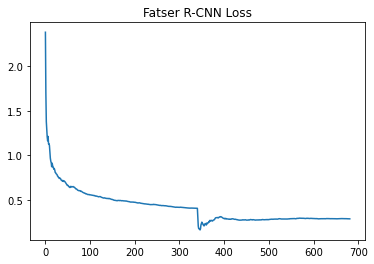

In [ ]:
plt.title('Fatser R-CNN Loss')

plt.plot(loss_list)
plt.show()


In [ ]:
def predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

In [ ]:
print('Mean IOU over train data set:', metric_func(train_loader)[0])
print('Mean Accuracy over train data set:',metric_func(train_loader)[1])

Mean IOU over train data set: 0.9478287487251856
Mean Accuracy over train data set: 0.85321700164122


In [ ]:
print('Mean IOU over test data set:', metric_func(test_loader)[0])
print('Mean Accuracy over test data set:',metric_func(test_loader)[1])

Mean IOU over test data set: 0.9057222407747432
Mean Accuracy over test data set: 0.8114466371529317


# visualizing the predicted bounding boxes 

In [ ]:
def draw_boxes(img, boxes,labels, thickness=1):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
        
    return bbox, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


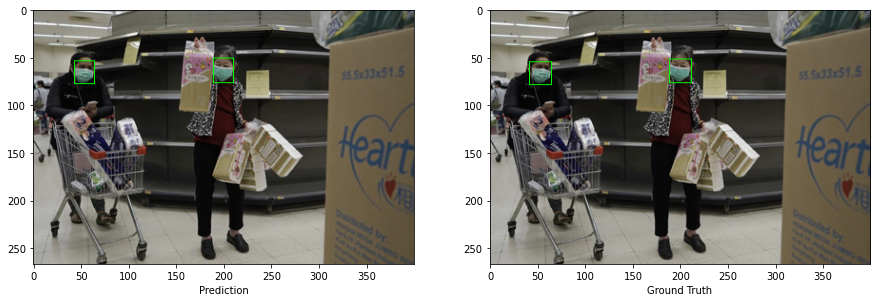

In [ ]:
from numpy import random

idx = random.randint(853)

test_img = Image.open(os.path.join(images_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], annotation_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()
